# 3. Model Evaluation

In this notebook, using the previously saved model files, we perform standard accuracy evaluations in two modes: classification of image sequences and classification of single images.

## Goal and logic
Set up the environment for PyTorch-based (potentially distributed) training: tensors/nn layers, data pipelines, optimizers/schedulers, vision datasets/transforms, serialization, plotting, and general utilities (time, OS, multiprocessing).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os, sys, gc
import time
from datetime import datetime
import copy
import random
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, TensorDataset, DistributedSampler
from torch.utils.data import Dataset, DataLoader, IterableDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler,SGD,Adam,AdamW,Adagrad,RMSprop
from PIL import Image
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from types import resolve_bases
import pickle
from sklearn.model_selection import train_test_split
import cloudpickle
import math

## Goal and logic
Choose the compute device for PyTorch operations

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Goal and logic
Ensure (as much as possible) reproducible results across runs by fixing the random number generator (RNG) states for Python, NumPy, and PyTorch, and forcing deterministic behavior.

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

## Goal and logic
Define run-time configuration for data handling and model input: image size, dataset root path, parallelism, and per-split batch sizes (see NB1)

In [4]:
IMG_SIZE=224
DATA_FOLDER="/MAIN/files20/"
THREADS = 16
BATCHES = {'train':4,'val':10,'gold':10}

## Goal and logic
Build a PyTorch Dataset that yields fixed-length, per-class image sequences. It optionally restricts to a subset of indices, shuffles indices per class each epoch, chunks them into non-overlapping sequences, loads images, applies a transform, and returns [T, C, H, W] sequences concatenated with zero-padding. (See NB1)

In [5]:
class SequenceFolder(Dataset):
    def __init__(self, root, seq_len, allowed_idxs=None, transform=None):
        self.folder     = ImageFolder(root)
        self.transform  = transform or transforms.ToTensor()
        self.seq_len    = seq_len

        # если передан список разрешённых изображений — используем его, иначе все сразу
        self.allowed = allowed_idxs or list(range(len(self.folder.samples)))

        # группируем разрешённые индексы по классам
        self.by_class = {}
        for i in self.allowed:
            _, label = self.folder.samples[i]
            self.by_class.setdefault(label, []).append(i)

        # initial fill
        self.on_epoch_end()

    def on_epoch_end(self):
        self.sequences = []
        self.labels    = []
        for label, idxs in self.by_class.items():
            random.shuffle(idxs)
            for i in range(0, len(idxs) - self.seq_len + 1, self.seq_len):
                chunk = idxs[i : i + self.seq_len]
                self.sequences.append(chunk)
                self.labels.append(label)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        chunk = self.sequences[idx]
        imgs  = []
        for i in chunk:
            path, _ = self.folder.samples[i]
            img = Image.open(path).convert('RGB')
            imgs.append(self.transform(img))       
        zeros =  torch.zeros((len(imgs)*2, ) + imgs[0].shape)
        zeros.permute(1,0,2,3)
        seq = torch.stack(imgs, dim=1).permute(1,0,2,3)  # [T, C, H, W]
        return torch.cat((seq, zeros), dim=0), self.labels[idx]

## Goal and logic
Build train/val/gold splits from an ImageFolder, wrap them with SequenceFolder using a given seq_len and transforms, optionally attach DistributedSamplers, create DataLoaders, persist a small “state” snapshot, and return loaders, sizes, and class names. (See NB1)

In [6]:
def get_loaders(seq_len=None,sampler=False, world_size=None, rank=None):
    batches=BATCHES
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'val': transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    }
    # 1. Получаем все индексы и их метки
    full_folder = ImageFolder(DATA_FOLDER)
    all_idxs   = list(range(len(full_folder.samples)))
    all_labels = [label for _, label in full_folder.samples]
    
    # 2. Стратифицированно сплитим их на train/val
    train_idxs, val_idxs = train_test_split(
        all_idxs,
        test_size=0.2,
        stratify=all_labels,
        random_state=42
    )
    train_idxs, gold_idxs = train_test_split(
        train_idxs,
        test_size=0.1,
        # stratify=all_labels,
        random_state=42
    )
    
    # 3. Создаем три датасета и три даталоадера
    image_datasets= {
        'train': SequenceFolder(DATA_FOLDER, seq_len,
                              allowed_idxs=train_idxs,
                              transform=data_transforms['train']),
        'val': SequenceFolder(DATA_FOLDER, seq_len,
                              allowed_idxs=val_idxs,
                              transform=data_transforms['val']),
        'gold': SequenceFolder(DATA_FOLDER, seq_len,
                              allowed_idxs=gold_idxs,
                              transform=data_transforms['val'])
    }
    class_names =image_datasets['train'].folder.classes
    state = {
        'train_idxs':  image_datasets["train"].allowed,
        'val_idxs':    image_datasets["val"].allowed,
        'gold_idxs':   image_datasets["gold"].allowed,
        'seq_len':     seq_len,
        'glob_pool':  -1 if 'GLOB_POOL' not in vars()  else GLOB_POOL,
        'img_size':    IMG_SIZE,
        'train_data_transforms': image_datasets["train"].transform,
        'val_data_transforms': image_datasets["val"].transform,
        'gold_data_transforms': image_datasets["gold"].transform,
        'class_names': class_names,
    }
    if sampler:
        samplers = image_datasets= {
            'train': DistributedSampler(image_datasets['train'], num_replicas=world_size, rank=rank),
            'val': DistributedSampler(image_datasets['val'], num_replicas=world_size, rank=rank),
            'gold': DistributedSampler(image_datasets['gold'], num_replicas=world_size, rank=rank)
        }
        dataloaders = {
            'train': DataLoader(image_datasets['train'], batch_size= batches['train'], shuffle=False,  num_workers=THREADS, sampler=samplers['train']),
            'val': DataLoader(image_datasets['val'],   batch_size= batches['val'] , shuffle=False, num_workers=THREADS, sampler=samplers['val']),
            'gold': DataLoader(image_datasets['gold'],   batch_size= batches['gold'] , shuffle=False, num_workers=THREADS, sampler=samplers['gold']),
            }
    else:
        dataloaders = {
            'train': DataLoader(image_datasets['train'], batch_size= batches['train'], shuffle=True,  num_workers=THREADS),
            'val': DataLoader(image_datasets['val'],   batch_size= batches['val'] , shuffle=True, num_workers=THREADS),
            'gold': DataLoader(image_datasets['gold'],   batch_size= batches['gold'] , shuffle=True, num_workers=THREADS),
            }
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','gold']}
    

    d = datetime.now()
    with open(f'rnn_conv_ds_{d.hour:02d}.{d.minute:02d}.{d.second:02d}.pkl', 'wb') as file:
        cloudpickle.dump(state, file)
    return dataloaders,dataset_sizes,class_names
dataloaders, dataset_sizes, class_names = get_loaders(seq_len=5)

## Goal and logic
Implement a single ConvLSTM cell: concatenates current input and previous hidden state, applies one 2D conv to produce all four gate tensors, normalizes and drops them out, computes LSTM-style gates (i,f,g,o), and returns updated hidden (h) and cell (c) states with the same spatial size.

In [7]:
class ConvLSTMCell(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernel_size, bias=True):
        super().__init__()
        self.hidden_channels = hidden_channels
        padding = kernel_size // 2
        # объединяем все 4 свёртки в одну с выходными каналами 4*hidden
        self.conv = nn.Conv2d(
            in_channels + hidden_channels,
            4 * hidden_channels,
            kernel_size,
            padding=padding,
            bias=bias
        )
        nn.init.constant_(self.conv.bias[self.hidden_channels:2*self.hidden_channels], -1.0)
        # self.norm = nn.InstanceNorm2d(4 * hidden_channels)#,affine=True)
        self.norm = nn.GroupNorm(32, 4 * hidden_channels)
        self.dropout = nn.Dropout2d(0.1)
        self.hidden_channels = hidden_channels

    def forward(self, x, hidden):
        h_prev, c_prev = hidden  # каждое: [B, hidden_channels, H, W]
        # конкатенация по каналам
        combined = torch.cat([x, h_prev], dim=1)
        conv_out = self.dropout(self.norm(self.conv(combined)))
        
        # разделим выход на 4 части
        cc_i, cc_f, cc_g, cc_o = torch.split(conv_out, self.hidden_channels, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        g = torch.tanh(cc_g)
        o = torch.sigmoid(cc_o)
        c = f * c_prev + i * g
        h = o * torch.tanh(c)
        return h, c

## Goal and logic
Build an image-sequence classifier using stacked ConvLSTM cells. Each time step is processed through all ConvLSTM layers with spatial downsampling (MaxPool) between layers; the last layer’s final hidden state is globally pooled and fed to a linear classifier. (See NB1)

In [8]:
class ConvLSTMClassifier(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=[32, 64, 128], 
                 kernel_size=3, num_classes=len(class_names), seq_len_train=None , glob_pool=None):
        super().__init__()
        self.seq_len_train=seq_len_train
        self.num_layers = len(hidden_channels)
        self.cells = nn.ModuleList()
        prev_channels = in_channels
        for h_ch in hidden_channels:
            self.cells.append(ConvLSTMCell(prev_channels, h_ch, kernel_size))
            prev_channels = h_ch
        self.maxpool= nn.MaxPool2d(2)

        # после последнего скрытого состояния — глобальный пулинг и FC
        self.global_pool = nn.AdaptiveAvgPool2d(glob_pool)
        N = hidden_channels[-1]*glob_pool**2
        # self.fc = nn.Sequential(nn.Linear(N, num_classes*2),nn.BatchNorm1d(num_classes*2),nn.ELU(), nn.Dropout(0.1),nn.Linear(num_classes*2,num_classes))
        self.fc = nn.Linear(N, num_classes)
        self.trans = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=.05, hue=0.03),    # hue=.05
            transforms.RandomRotation((-20,20),interpolation=transforms.InterpolationMode.BILINEAR), # аугментация, попробовать в конце!
        ])

    def forward(self, x_seq):
        """
        x_seq: тензор [B, T, C, H, W]
        """
        B, T, C, H, W = x_seq.shape
        # инициализируем состояния нулями
        h = []
        H_=H
        W_=W
        for ch in [cell.hidden_channels for cell in self.cells]:
            h.append(torch.zeros(B, ch, H_, W_, device=x_seq.device))
            H_ //=2
            W_ //=2
        c = [torch.zeros_like(h_i) for h_i in h]

        # разбиваем последовательность по шагам
        for t in range(T):
            x = x_seq[:, t]  # [B, C, H, W]
            for l, cell in enumerate(self.cells):
                h[l], c[l] = cell(x, (h[l], c[l]))
                x = self.maxpool(h[l])  # вход для следующего слоя

        # берем последнее скрытое состояние верхнего слоя
        out = self.global_pool(h[-1]).view(B, -1)  # [B, hidden]
        logits = self.fc(out)  # [B, num_classes]
        return logits

    def prep_batch(self, inputs):
        for b in range(len(inputs)):
            n = inputs[b].shape[0]//3
            t = random.randint(0, n-1)
            for i in range(n):
                if i==t: continue
                inputs[b][i] = self.trans(torch.clone(inputs[b][t]))
                # inputs[b][i] = torch.clone(inputs[b][t])

## Goal and Logic
Restore the saved dataset/split configuration and rebuild the PyTorch datasets/dataloaders for the three phases (train/val/gold), so that inference for testing and model evaluation runs on data that was not used during training.

In [9]:
batches=BATCHES = {'train':2,'val':10,'gold':10}
DATA_FOLDER = "/MAIN/files20"
# 1) Загружаем состояние
with open('rnn_conv_ds_08.12.54.pkl', 'rb') as f:
    state = cloudpickle.load(f)

# 2) Вытаскиваем всё
train_idxs = state['train_idxs']
val_idxs = state['val_idxs']
gold_idxs = state['gold_idxs']
SEQ_LEN  = state['seq_len']
IMG_SIZE = state['img_size']
data_transforms = {"train":state['train_data_transforms'],
    "val": state['val_data_transforms'],
    "gold": state['gold_data_transforms'],
      }
class_names     = state['class_names']

# 3) Реконструируем DataLoader’ы «на лету»
image_datasets= {
    'train': SequenceFolder(DATA_FOLDER, SEQ_LEN,
                          allowed_idxs=train_idxs,
                          transform=data_transforms['train']),
    'val': SequenceFolder(DATA_FOLDER, SEQ_LEN,
                          allowed_idxs=val_idxs,
                          transform=data_transforms['val']),
    'gold': SequenceFolder(DATA_FOLDER, SEQ_LEN,
                          allowed_idxs=gold_idxs,
                          transform=data_transforms['gold'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size= batches['train'], shuffle=True,  num_workers=10),
    'val': DataLoader(image_datasets['val'],   batch_size= batches['val'] , shuffle=True, num_workers=10),
    'gold': DataLoader(image_datasets['gold'],   batch_size= batches['gold'] , shuffle=True, num_workers=10),
    }
dataset_sizes = { 'train': len(image_datasets['train']), 'val': len(image_datasets["val"]) , 'gold': len(image_datasets["gold"])}

## Goal and logic
Load a saved PyTorch model/checkpoint from disk into the variable model. The active line loads rnn_conv_11.26.30.pth; the others are alternative checkpoints commented out.

In [10]:
# model = torch.load("rnn_conv_12.31.18.pth")
# model = torch.load("rnn_conv_10.32.43.pth")
model = torch.load("rnn_conv_11.26.30.pth")


/tmp/ipykernel_233297/3660536424.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("rnn_conv_11.26.30.pth")


## Goal and logic
Compute and print the total number of trainable (requires_grad=True) parameters in the model

In [11]:
trainable_params = sum(
    p.numel()        # возвращает количество элементов в тензоре
    for p in model.parameters()
    if p.requires_grad  # только параметры, которые участвуют в градиенте
)

print(f"Количество обучаемых параметров: {trainable_params}")

Количество обучаемых параметров: 4711444


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Goal and logic
* Purpose: visualize one sample from the validation dataloader as an image grid and show its label(s).
* Flow: fetch a batch (inputs, classes) → take the first sample → make a grid (potentially of its frames if it’s a sequence) → denormalize in imshow → display with a title.

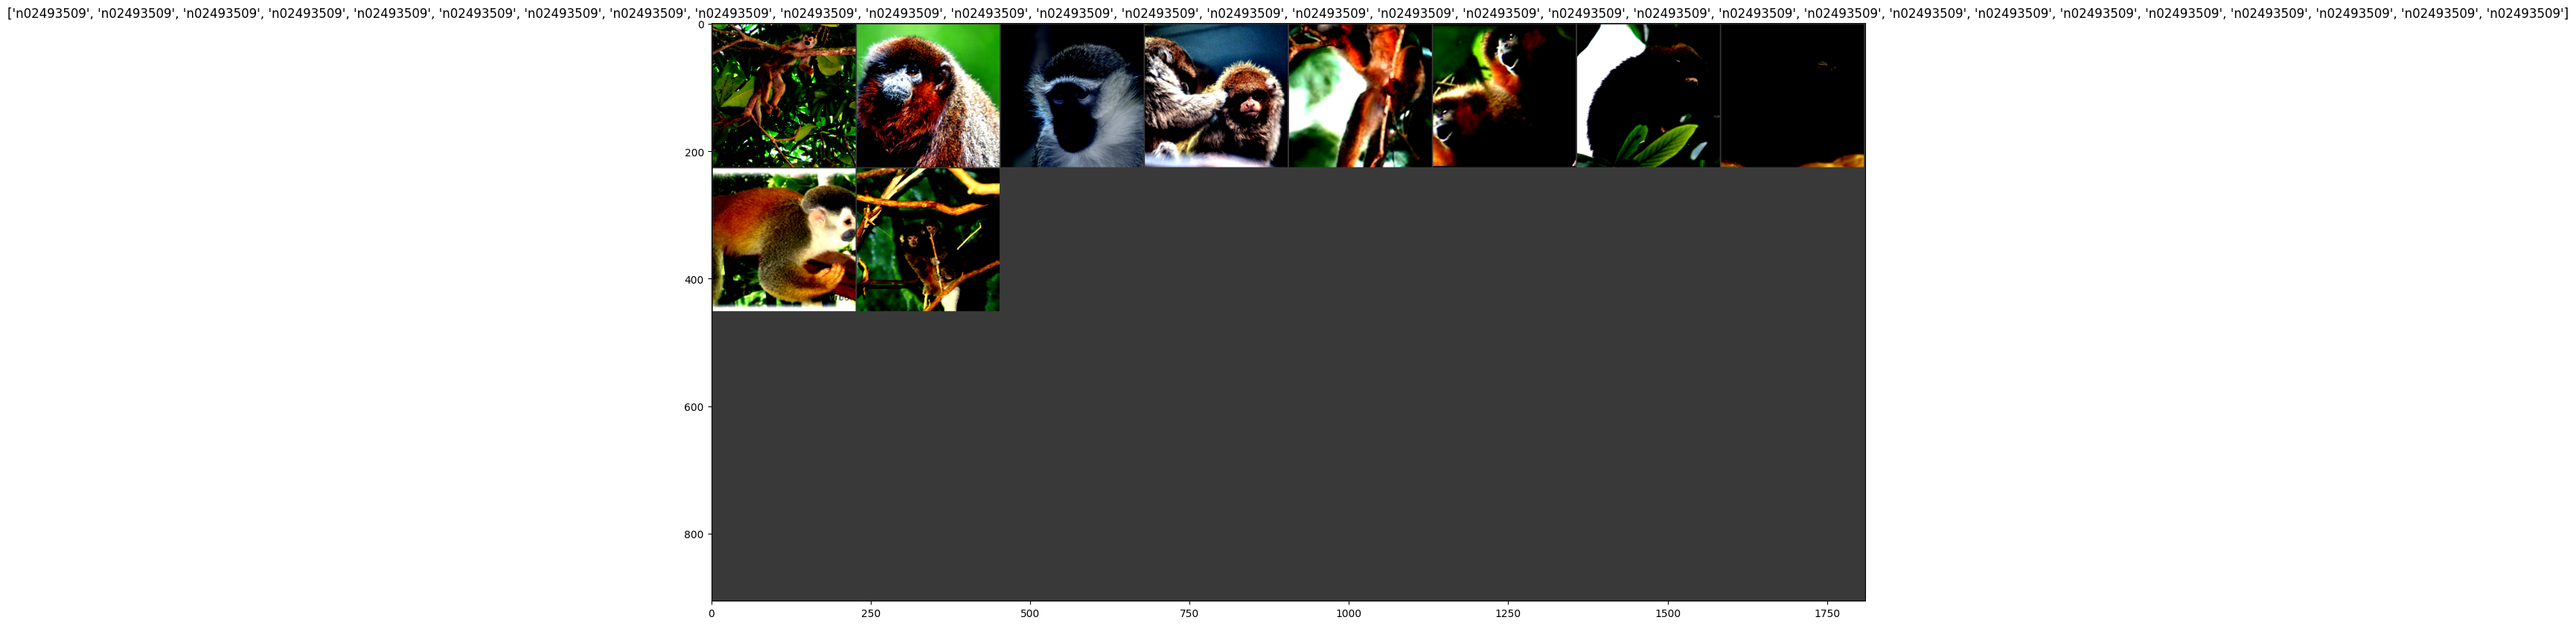

In [13]:
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    mean=  torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std= torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    inp = inp * mean
    inp = inp + std
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    # plt.imsave("dataset_samples.png",inp)
    plt.show()
    # with open("dataset_samples.txt", "w") as output:
    #     output.write(str(title))
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0])
plt.figure(figsize=(20,20))
cl = [int(classes[0])] * inputs[0].shape[0]
imshow(out, title=[class_names[c] for c in cl])

## Goal and logic
Briefly: the model runs in inference mode over the gold split; the input is batches—sequences of images with their class labels. We collect the true and predicted classes (as text) and compute the average cross-entropy loss and accuracy over the entire split; memory is cleared after each batch.

In [14]:
criterion = nn.CrossEntropyLoss()
true_classes = []
pred_classes = []
running_corrects = running_loss = cnt = 0
for inputs, labels in dataloaders["gold"]:
    true_classes += [class_names[l] for l in labels]
    cnt += len(labels)
    with torch.inference_mode():
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        pred_classes += [class_names[c] for c in preds]
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    gc.collect()
    torch.cuda.empty_cache()
epoch_loss = running_loss / dataset_sizes["gold"]
epoch_acc = running_corrects.double() / dataset_sizes["gold"]

Very good accuracy (0.954), but only during inference on a _group_ of images.

In [15]:
epoch_acc

tensor(0.9538, device='cuda:0', dtype=torch.float64)

## Goal and logic
* Goal: Build and visualize a confusion matrix, focusing only on classes involved in any misclassification.
* Logic: Compute the confusion matrix → identify classes with at least one error (either as true or predicted) → filter rows/columns to those classes → plot a heatmap with readable labels.

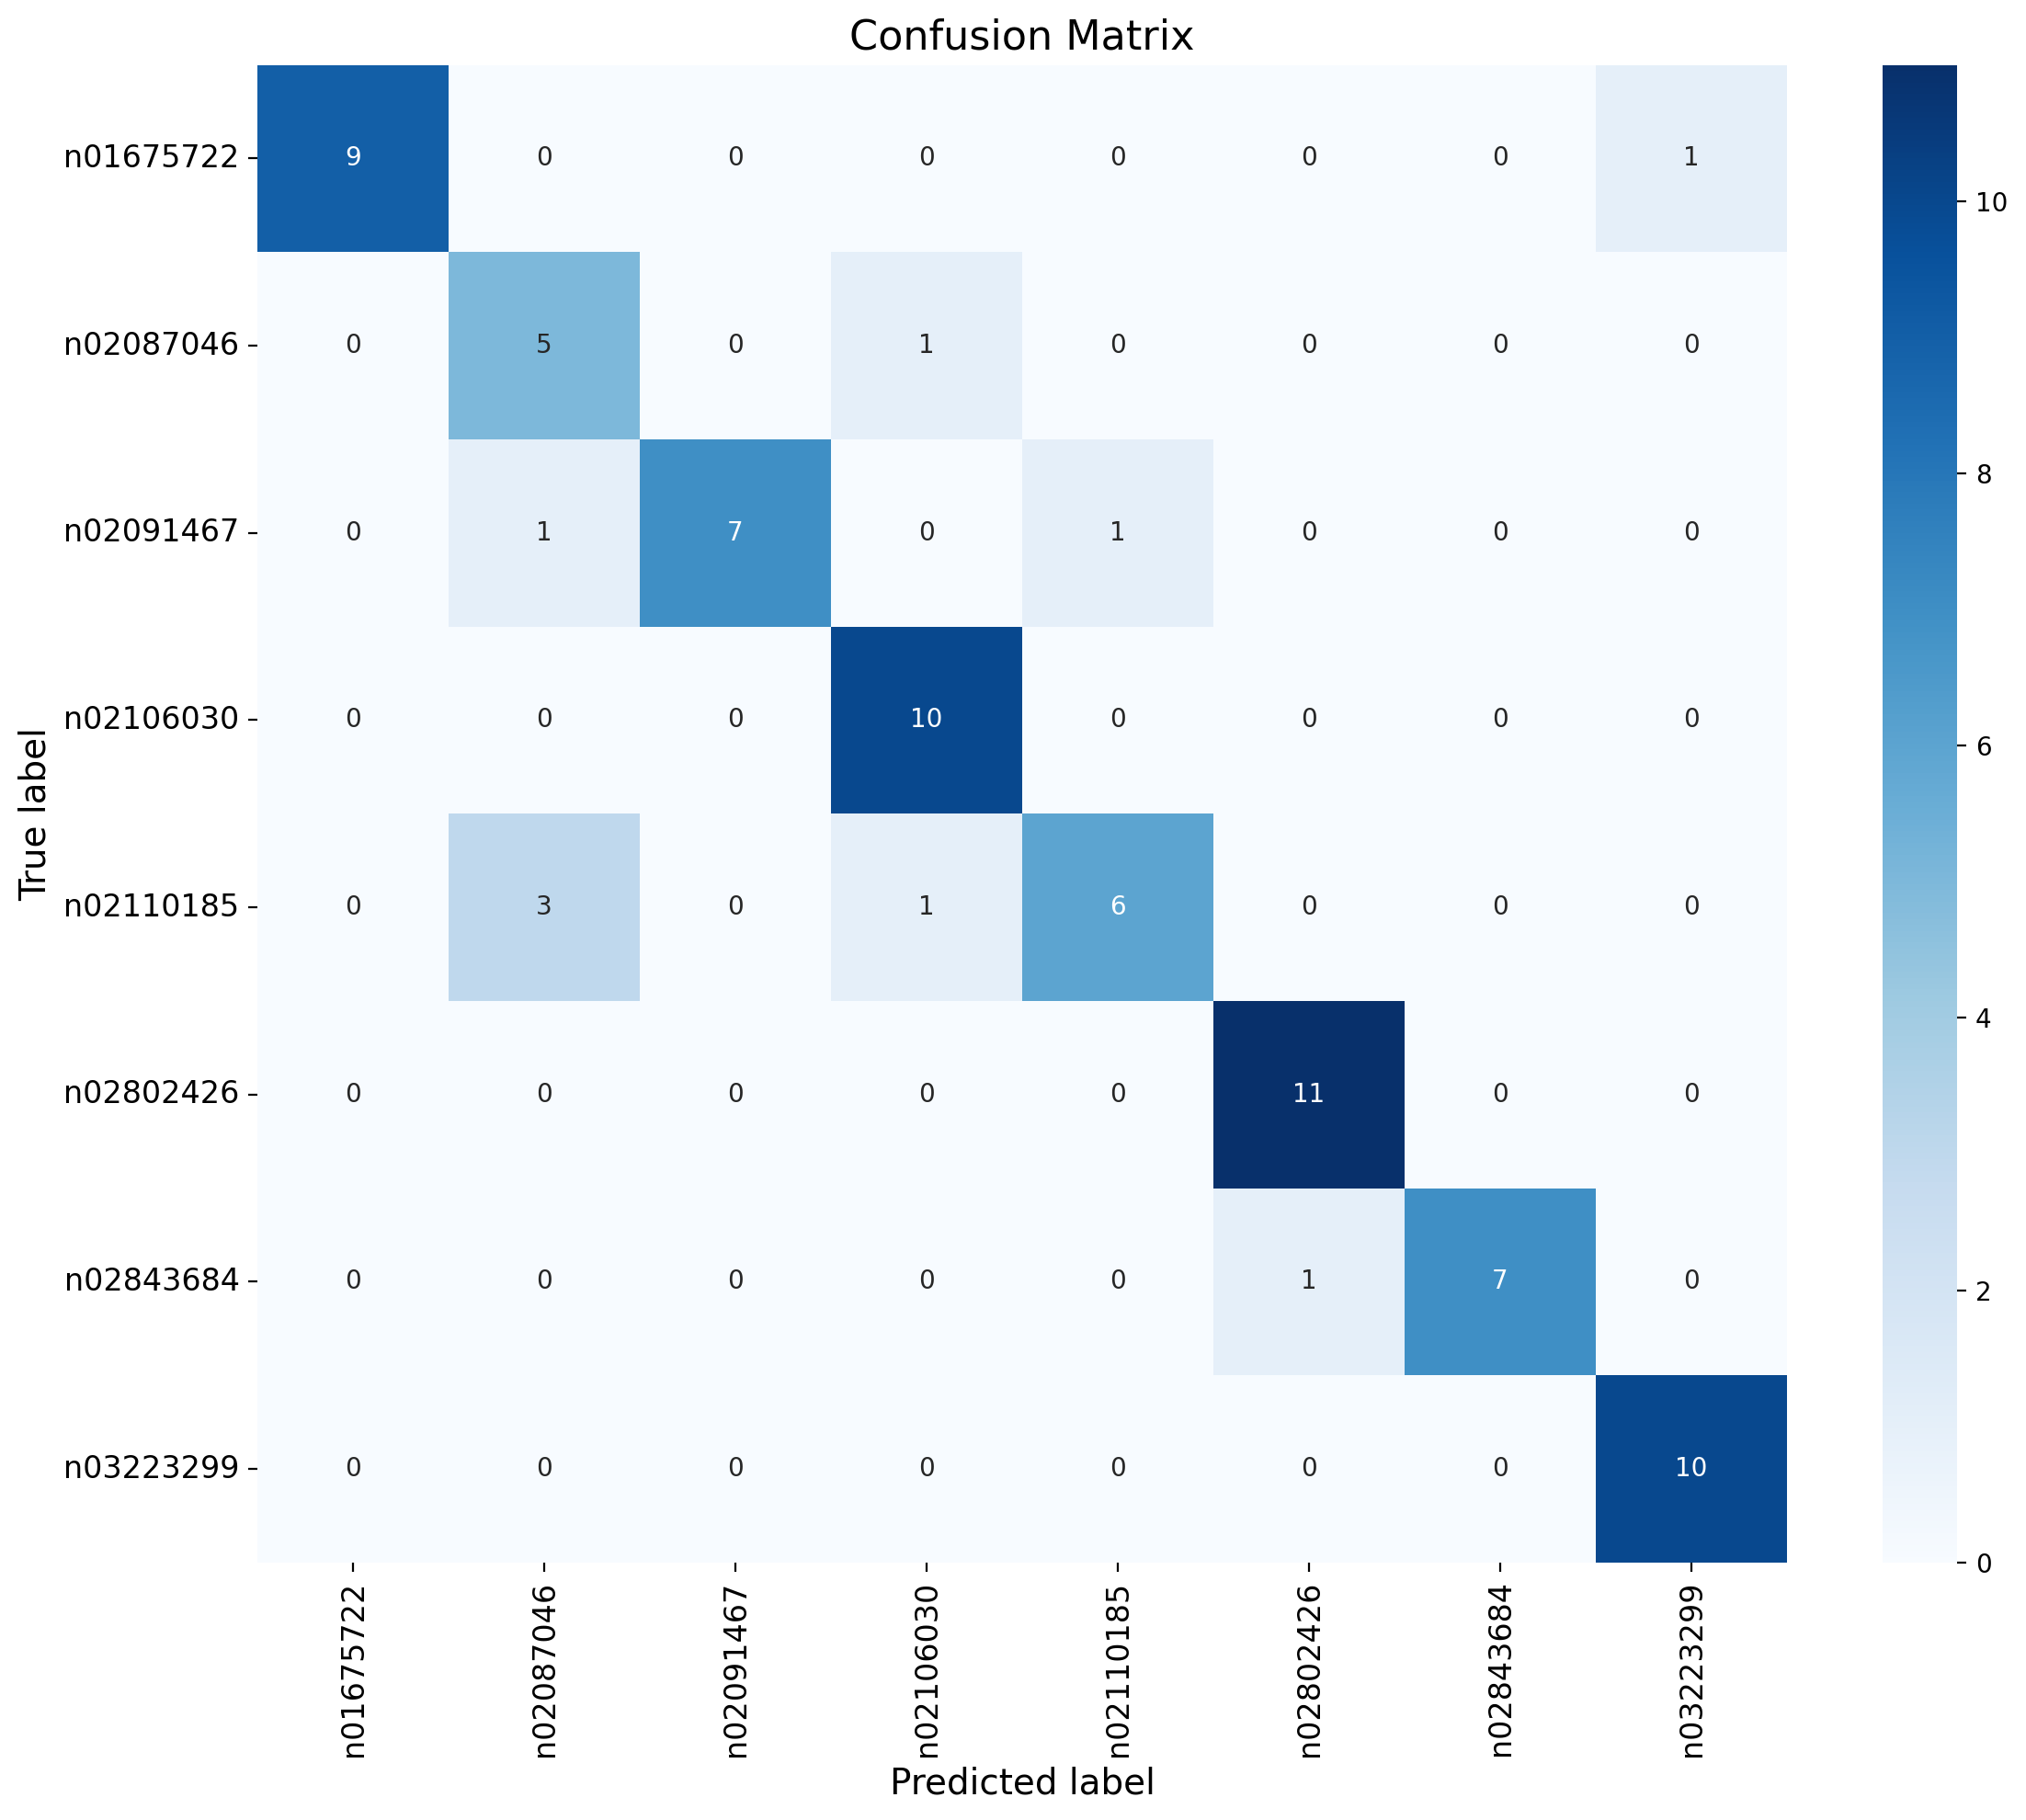

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_classes, pred_classes, labels=class_names)
has_errors = (
    (cm.sum(axis=1) - np.diag(cm) > 0)  # ошибки по истинным меткам
    | 
    (cm.sum(axis=0) - np.diag(cm) > 0)  # ошибки по предсказанным меткам
)

# 3) Отфильтровываем и строки, и столбцы
labels_err = np.array(class_names)[has_errors]
cm_err = cm[np.ix_(has_errors, has_errors)]

plt.figure(figsize=(12, 10), dpi=200) 
sns.heatmap(
    cm_err,
    annot=True,
    fmt='d',
    xticklabels=labels_err,
    yticklabels=labels_err,
    cmap='Blues',
    # cbar_kws={'shrink': 0.8}   # опционально — чуть уменьшить панель цвета
)

# Развернуть подписи по оси X
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.tight_layout()
plt.show()

## Evaluating performance on single images
In the remainder of the notebook, we evaluate the model when the input is a single image rather than a sequence. For compatibility with the model’s logic, we still wrap it into a length-1 sequence. This can be either the unchanged image (a single copy) or a set of its augmented variants.

## Goal and logic
* define a set of alternative image augmentation pipelines with increasing strength to use in training or evaluation (e.g., ablation/TTA).
* create multiple transforms.Compose variants, from no-op to heavy augmentations (flip → flip+rotate → flip+color+rotate → add perspective/affine → add erasing).

In [17]:
transformations=[
    transforms.Compose([
    ]),
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
    ]),
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation((-20,20),interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # аугментация, попробовать в конце!
    ]),
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=.05, hue=0.03),    # hue=.05
        transforms.RandomRotation((-20,20),interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # аугментация, попробовать в конце!
    ]),
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=.05, hue=0.03),    # hue=.05
        transforms.RandomRotation((-10,10),interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # аугментация, попробовать в конце!
    ]),
        transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=.05, hue=0.03),    # hue=.05
        transforms.RandomPerspective(distortion_scale=0.5, p=0.2),
                transforms.RandomAffine(
                degrees=0,
                translate=(0.1,0.1),
                scale=(0.8,1.2),
                shear=10
            ),
        # transforms.RandomRotation((-10,10),interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # аугментация, попробовать в конце!
    ]),
        transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomErasing(
                p=0.25,
                scale=(0.02,0.33),
                ratio=(0.3,3.3),
                value='random'
            ),
        transforms.ColorJitter(brightness=.05, hue=0.03),    # hue=.05
         transforms.RandomPerspective(distortion_scale=0.5, p=0.2),
                transforms.RandomAffine(
                degrees=0,
                translate=(0.1,0.1),
                scale=(0.8,1.2),
                shear=10
            ),
        transforms.RandomRotation((-10,10),interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # аугментация, попробовать в конце!
    ]),
]

## Goal and logic
* create multiple augmented “views” of a selected item within each sub-batch/bag.
* for each b in the batch, pick an index t (anchor) within the first third of items, then overwrite the first third (except t) with copies or transformed copies of item t; the rest of the items remain unchanged.
## Key variables and how they are used
* inputs: tensor-like batch, expected shape [B, N, ...]; cloned to avoid modifying the original.
* b: batch index iterating over B.
* n: number of items in the b-th sub-batch (N).
* t: anchor index within [0, n//3] (inclusive) used as the source item; if provided, used as-is; if None, sampled once and reused for all b.
* trans: optional augmentation callable applied to the cloned anchor before assignment.

In [18]:
def prep_batch(inputs, t=None, trans=None):
    inputs = inputs.clone()
    for b in range(len(inputs)):
        n = inputs[b].shape[0]
        if t is None:
            t = random.randint(0, n//3)
        for i in range(n//3):
            if i==t: continue
            if trans is not None:
                inputs[b][i] = trans(torch.clone(inputs[b][t]))
            else:
                inputs[b][i] = torch.clone(inputs[b][t])
    return inputs    

## Goal and logic
Goal: evaluate model accuracy (and loss) on the “gold” split for each candidate augmentation transform.
Logic: for each batch, iterate over anchor indices t within the first third of the per-sample sequence, build augmented inputs via prep_batch, run the model, accumulate loss and corrects, then average over all samples and all t. Print the transform and its accuracy.

## Key variables and how they are used
* trans: augmentation under test; passed to prep_batch.
* criterion: nn.CrossEntropyLoss used to compute batch loss.
* dataloaders["gold"], dataset_sizes["gold"]: evaluation data and total sample count for normalization.
* N: number of anchor positions evaluated per batch = len(inputs_[0]) // 3 (must match prep_batch’s “first third” convention).
* inputs_, labels: batch tensors; inputs is rebuilt per t via prep_batch, then moved to device.
* running_loss, running_corrects: accumulators across all batches and t. cnt exists but is unused.
* model, device: global model and compute device.

In [19]:
def check_acc(trans):
    criterion = nn.CrossEntropyLoss()
    running_corrects = running_loss = cnt = 0
    for inputs_, labels in dataloaders["gold"]:
        N = len(inputs_[0])//3
        cnt += len(labels)
        with torch.inference_mode():
            for t in range(N):
                inputs = prep_batch(inputs_,t,trans)
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                # pred_classes += [class_names[c] for c in preds]
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        gc.collect()
        torch.cuda.empty_cache()
    epoch_loss = running_loss / (N * dataset_sizes["gold"])
    epoch_acc = running_corrects.double() / (N * dataset_sizes["gold"])
    print(trans)
    print(epoch_acc)
    print("---")

for trans in transformations:
    check_acc(trans)

Compose(
)
tensor(0.6472, device='cuda:0', dtype=torch.float64)
---
Compose(
    RandomHorizontalFlip(p=0.5)
)
tensor(0.6426, device='cuda:0', dtype=torch.float64)
---
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-20.0, 20.0], interpolation=bilinear, expand=False, fill=0)
)
tensor(0.5785, device='cuda:0', dtype=torch.float64)
---
Compose(
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.95, 1.05), contrast=None, saturation=None, hue=(-0.03, 0.03))
    RandomRotation(degrees=[-20.0, 20.0], interpolation=bilinear, expand=False, fill=0)
)
tensor(0.7087, device='cuda:0', dtype=torch.float64)
---
Compose(
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.95, 1.05), contrast=None, saturation=None, hue=(-0.03, 0.03))
    RandomRotation(degrees=[-10.0, 10.0], interpolation=bilinear, expand=False, fill=0)
)
tensor(0.7128, device='cuda:0', dtype=torch.float64)
---
Compose(
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.95, 1.05), co

## Conclusion.

The best single-image accuracy was obtained with light augmentation, reaching *0.7128*, which is comparable to the performance of state-of-the-art, very deep reference models on this dataset (see the subsequent notebooks).